# November 5, 2025 CRL Tank Tests — SNR Analysis

Per-ping signal-to-noise ratio analysis for 10 test recordings from the CRL tank,
each with a different configuration (target, chirp direction, transmit power)
to characterize the echobot system's noise performance and reverberation.

**SNR definition** (consistent across all tests):
- **Signal**: peak matched-filter envelope amplitude in the floor region [2.5, 5.0] m
- **Noise**: mean matched-filter envelope amplitude in the empty region [2.0, 2.5] m
- **SNR** = 20 · log₁₀(V_peak / V_mean) — voltage domain

**Setup**: ES 120-18CDK split transducer in CRL tank, transducer ~30 cm below surface
in corner (~1 m from two sides), pointing straight down. Targets suspended directly below
at ~140–150 cm range.

In [1]:
import numpy as np
import scipy.io as sio
from scipy.signal import firwin, lfilter, correlate
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 4)

DATA_DIR = '../../Data/1105-CRL-tests'

# SNR gate definitions (same as cross-comparison notebook)
NOISE_GATE = [2.0, 2.5]    # empty water between target (~1.5 m) and floor (~3 m)
FLOOR_GATE = [2.5, 5.0]    # tank floor search region


def analyze_test(mat_path, test_num, description):
    """Load a .mat file, compute per-ping tank floor SNR, and plot results.

    Returns the per-ping SNR array.
    """
    # ---- Load ----
    S = sio.loadmat(mat_path, squeeze_me=False)
    data = S['data']
    hdr = S['header'][0, 0]

    fs = float(hdr['fs'].flat[0])
    c = float(hdr['c'].flat[0]) if 'c' in hdr.dtype.names else 1486.0
    s_chirp = hdr['s_chirp'].flatten()
    T_pre = float(hdr['T_pre'].flat[0])
    T_post = float(hdr['T_post'].flat[0])
    fqi = float(hdr['fqi'].flat[0]) if 'fqi' in hdr.dtype.names else 0
    fqf = float(hdr['fqf'].flat[0]) if 'fqf' in hdr.dtype.names else 0

    Ns, n_ch, n_pings = data.shape
    R = 0.5 * c * np.arange(Ns) / fs

    # TX reference (zero-padded chirp)
    n_pre = int(round(T_pre * fs))
    n_post = int(round(T_post * fs))
    tx_ref = np.concatenate([np.zeros(n_pre), s_chirp, np.zeros(n_post)])
    n_ref = len(tx_ref)

    # Bandpass filter (80–175 kHz, matching echobot pipeline)
    lp = firwin(101, 175e3, fs=fs)
    hp = firwin(101, 80e3, fs=fs, pass_zero=False)
    def bp(x):
        return lfilter(hp, 1.0, lfilter(lp, 1.0, x))

    # Gate indices
    j0n = np.searchsorted(R, NOISE_GATE[0])
    j1n = np.searchsorted(R, NOISE_GATE[1], side='right')
    j0f = np.searchsorted(R, FLOOR_GATE[0])
    j1f = np.searchsorted(R, FLOOR_GATE[1], side='right')

    # Per-ping SNR from summed-sector MF envelope
    snr = np.zeros(n_pings)
    for p in range(n_pings):
        secs = []
        for ch in range(min(n_ch, 3)):   # 3 active sectors
            df = bp(data[:, ch, p])
            cc = correlate(df, tx_ref, mode='full')
            secs.append(cc[n_ref - 1 : n_ref - 1 + Ns])
        env = np.abs(sum(secs))
        floor_pk = np.max(env[j0f:j1f])
        noise_mn = np.mean(env[j0n:j1n])
        snr[p] = 20 * np.log10(floor_pk / (noise_mn + 1e-30))

    # ---- Plot ----
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    ax = axes[0]
    ax.plot(np.arange(n_pings), snr, 'o-', ms=4, color='C0', alpha=0.7)
    ax.axhline(snr.mean(), color='k', ls='--', lw=0.8,
               label=f'mean = {snr.mean():.1f} dB')
    ax.fill_between(np.arange(n_pings),
                    snr.mean() - snr.std(), snr.mean() + snr.std(),
                    alpha=0.1, color='C0')
    ax.set_xlabel('Ping index')
    ax.set_ylabel('SNR (dB)')
    ax.set_title(f'Test {test_num}: Floor SNR Time Series')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    n_bins = max(5, n_pings // 4)
    ax.hist(snr, bins=n_bins, alpha=0.7, color='C0',
            edgecolor='k', linewidth=0.5)
    ax.axvline(snr.mean(), color='k', ls='--', lw=0.8,
               label=f'mean = {snr.mean():.1f} dB')
    ax.set_xlabel('SNR (dB)')
    ax.set_ylabel('Count')
    ax.set_title(f'Test {test_num}: SNR Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    chirp_dir = 'upsweep' if fqi < fqf else 'downsweep'
    print(f'  fs = {fs/1e3:.0f} kHz, c = {c:.0f} m/s, '
          f'chirp = {len(s_chirp)} samples ({len(s_chirp)/fs*1e3:.2f} ms), '
          f'{chirp_dir} {fqi/1e3:.0f}\u2192{fqf/1e3:.0f} kHz')
    print(f'  Channels: {n_ch}, Pings: {n_pings}')
    print(f'  Floor SNR: mean = {snr.mean():.1f} dB, std = {snr.std():.2f} dB, '
          f'min = {snr.min():.1f} dB, max = {snr.max():.1f} dB')

    return snr


# Store results for summary comparison
all_results = {}
print('Helper functions loaded.')

Helper functions loaded.


## Test 1: Baseline reverberation measurement

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T120308_020.mat` |
| **TX Power** | +3.0 dB |
| **Target** | None (empty water) |
| **Target State** | N/A |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 20 |
| **Notes** | Baseline reverberation measurement — no target in water |

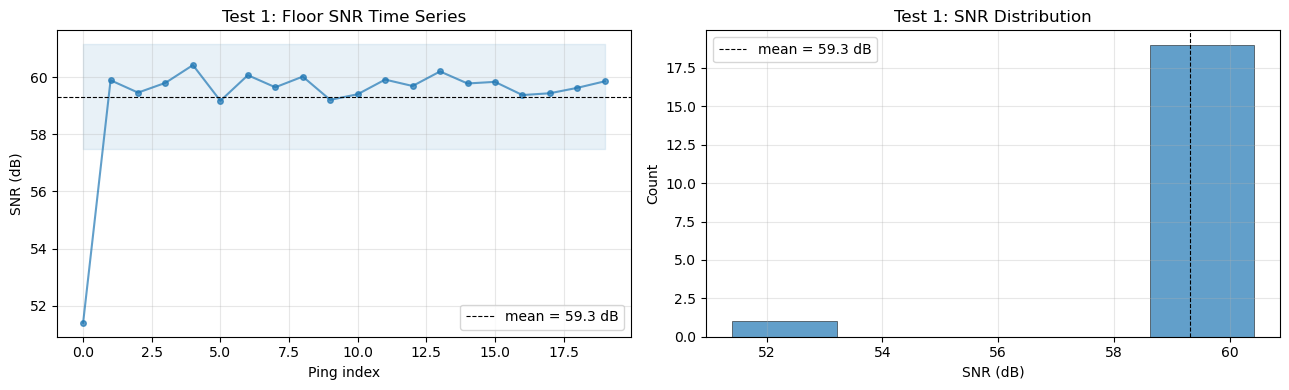

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 20
  Floor SNR: mean = 59.3 dB, std = 1.84 dB, min = 51.4 dB, max = 60.4 dB


In [2]:
snr_1 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T120308_020.mat'),
    test_num=1,
    description='Baseline reverberation measurement — no target in water'
)
all_results['Test 1'] = snr_1

## Test 2: Baseline reverberation

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T120550_020.mat` |
| **TX Power** | +3.0 dB |
| **Target** | None (empty water) |
| **Target State** | N/A |
| **Chirp** | Downsweep (150 → 90 kHz) |
| **Pings** | 20 |
| **Notes** | Baseline reverberation — downsweep chirp, no target |

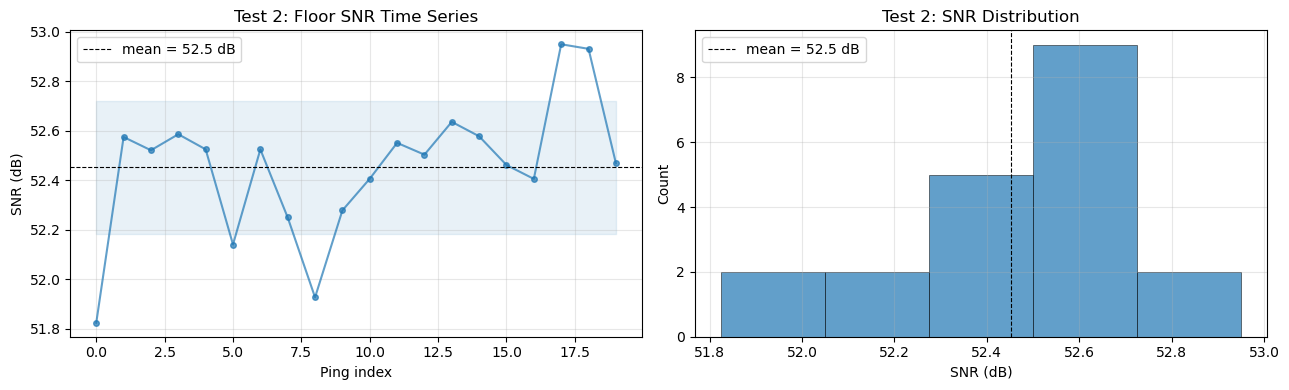

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 150→90 kHz
  Channels: 5, Pings: 20
  Floor SNR: mean = 52.5 dB, std = 0.27 dB, min = 51.8 dB, max = 52.9 dB


In [3]:
snr_2 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T120550_020.mat'),
    test_num=2,
    description='Baseline reverberation — downsweep chirp, no target'
)
all_results['Test 2'] = snr_2

## Test 3: 38 mm sphere, stationary, downsweep

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T121721_020.mat` |
| **TX Power** | +3.0 dB |
| **Target** | 38 mm WC sphere |
| **Target State** | Stationary |
| **Chirp** | Downsweep (150 → 90 kHz) |
| **Pings** | 20 |
| **Notes** | 38 mm sphere, stationary, downsweep |

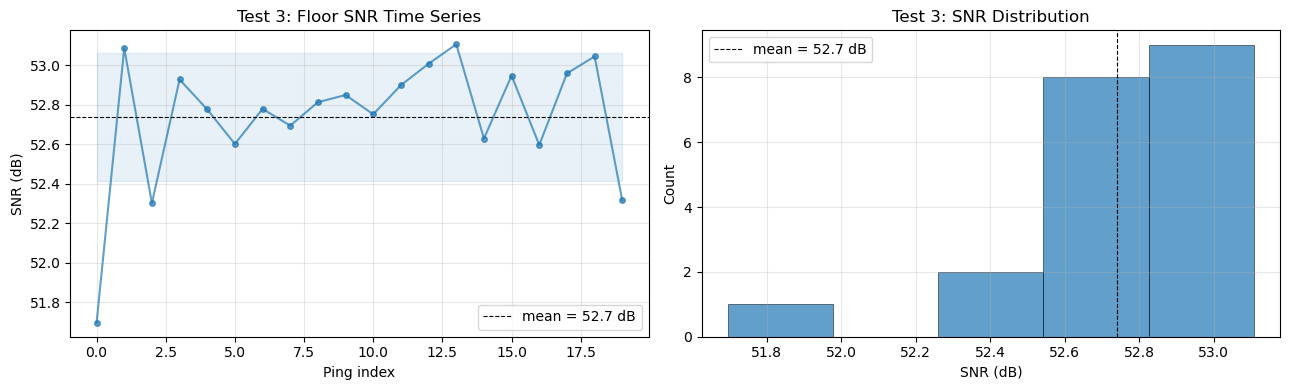

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 150→90 kHz
  Channels: 5, Pings: 20
  Floor SNR: mean = 52.7 dB, std = 0.32 dB, min = 51.7 dB, max = 53.1 dB


In [4]:
snr_3 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T121721_020.mat'),
    test_num=3,
    description='38 mm sphere, stationary, downsweep'
)
all_results['Test 3'] = snr_3

## Test 4: Transducer replaced with 65 Ω dummy load

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T122733_020.mat` |
| **TX Power** | +3.0 dB |
| **Target** | N/A — dummy transducer (65 Ω resistor) |
| **Target State** | N/A |
| **Chirp** | Downsweep (150 → 90 kHz) |
| **Pings** | 20 |
| **Notes** | Transducer replaced with 65 Ω dummy load — measures electronic noise floor |

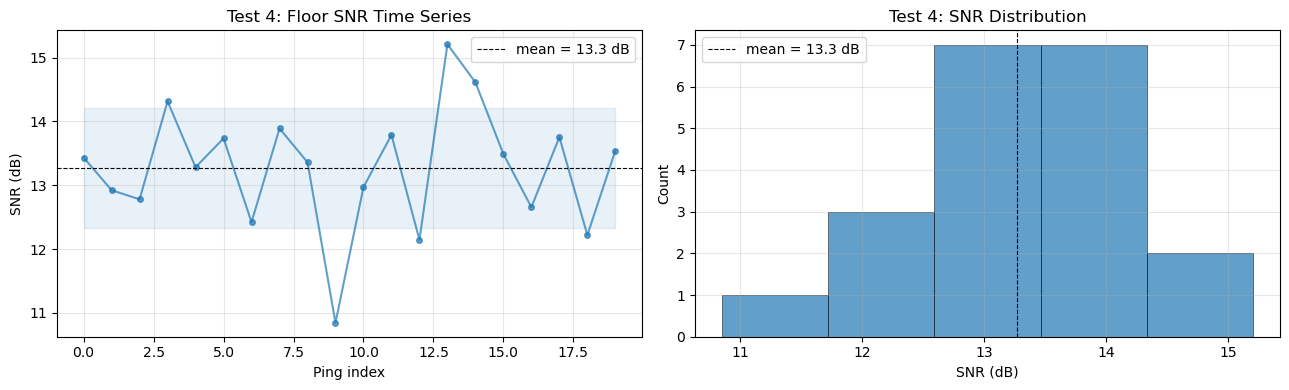

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 150→90 kHz
  Channels: 5, Pings: 20
  Floor SNR: mean = 13.3 dB, std = 0.94 dB, min = 10.8 dB, max = 15.2 dB


In [5]:
snr_4 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T122733_020.mat'),
    test_num=4,
    description='Transducer replaced with 65 Ω dummy load — measures electronic noise floor'
)
all_results['Test 4'] = snr_4

## Test 5: Transducer reconnected but power amp unpowered

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T123400_020.mat` |
| **TX Power** | +3.0 dB |
| **Target** | N/A — power amplifier unpowered |
| **Target State** | N/A |
| **Chirp** | Downsweep (150 → 90 kHz) |
| **Pings** | 20 |
| **Notes** | Transducer reconnected but power amp unpowered — measures receive-chain noise floor |

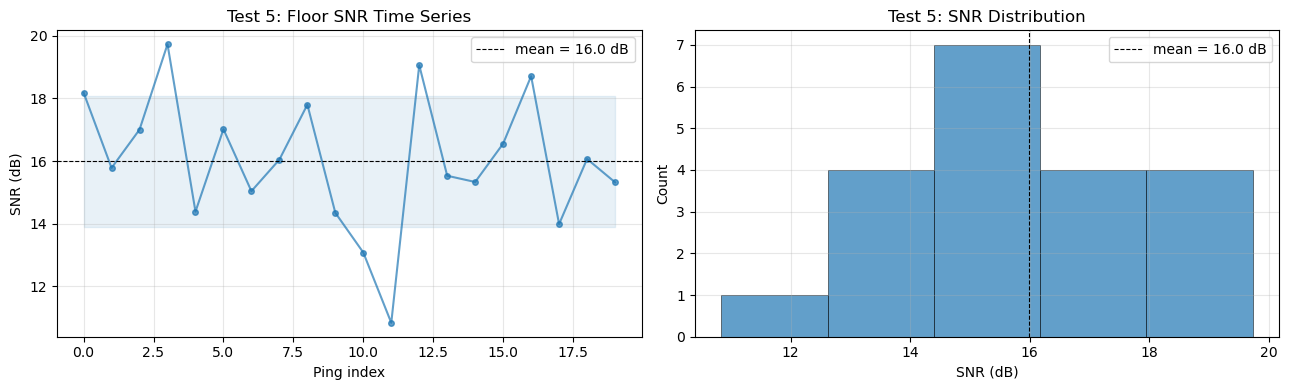

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 150→90 kHz
  Channels: 5, Pings: 20
  Floor SNR: mean = 16.0 dB, std = 2.09 dB, min = 10.8 dB, max = 19.7 dB


In [6]:
snr_5 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T123400_020.mat'),
    test_num=5,
    description='Transducer reconnected but power amp unpowered — measures receive-chain noise floor'
)
all_results['Test 5'] = snr_5

## Test 6: 38 mm sphere, moving, downsweep

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T124029_100.mat` |
| **TX Power** | +3.0 dB |
| **Target** | 38 mm WC sphere |
| **Target State** | Moving |
| **Chirp** | Downsweep (150 → 90 kHz) |
| **Pings** | 100 |
| **Notes** | 38 mm sphere, moving, downsweep — same as Sept 4 acquisition |

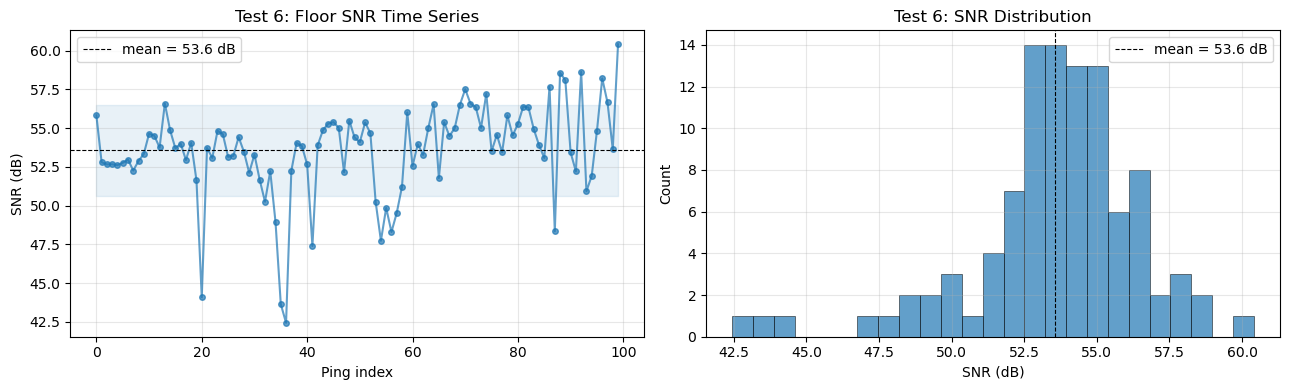

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 150→90 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 53.6 dB, std = 2.96 dB, min = 42.4 dB, max = 60.4 dB


In [7]:
snr_6 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T124029_100.mat'),
    test_num=6,
    description='38 mm sphere, moving, downsweep — same as Sept 4 acquisition'
)
all_results['Test 6'] = snr_6

## Test 7: 38 mm sphere, moving, upsweep

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T125313_100.mat` |
| **TX Power** | +3.0 dB |
| **Target** | 38 mm WC sphere |
| **Target State** | Moving |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 100 |
| **Notes** | 38 mm sphere, moving, upsweep — compare with Test 6 for chirp direction effect |

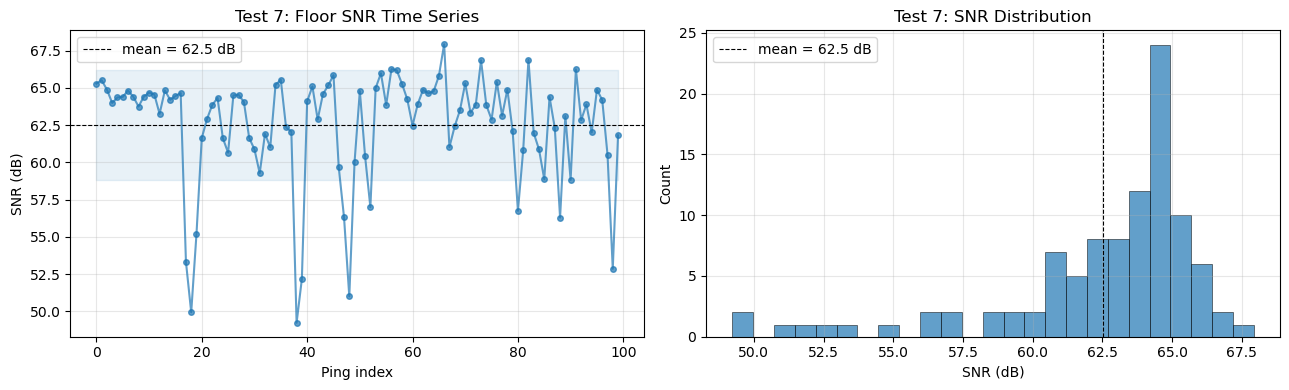

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 62.5 dB, std = 3.71 dB, min = 49.2 dB, max = 67.9 dB


In [8]:
snr_7 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T125313_100.mat'),
    test_num=7,
    description='38 mm sphere, moving, upsweep — compare with Test 6 for chirp direction effect'
)
all_results['Test 7'] = snr_7

## Test 8: Smaller 22 mm sphere, moving, upsweep

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T130710_100.mat` |
| **TX Power** | +3.0 dB |
| **Target** | 22 mm WC sphere |
| **Target State** | Moving |
| **Chirp** | Upsweep (90 → 150 kHz) |
| **Pings** | 100 |
| **Notes** | Smaller 22 mm sphere, moving, upsweep |

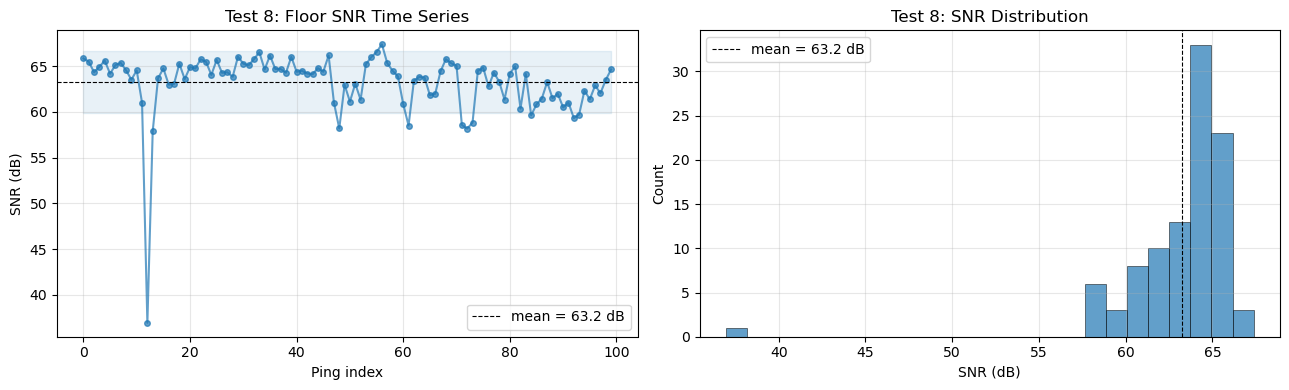

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), upsweep 90→150 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 63.2 dB, std = 3.40 dB, min = 37.0 dB, max = 67.4 dB


In [9]:
snr_8 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T130710_100.mat'),
    test_num=8,
    description='Smaller 22 mm sphere, moving, upsweep'
)
all_results['Test 8'] = snr_8

## Test 9: 22 mm sphere, moving, downsweep

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T131215_100.mat` |
| **TX Power** | +3.0 dB |
| **Target** | 22 mm WC sphere |
| **Target State** | Moving |
| **Chirp** | Downsweep (150 → 90 kHz) |
| **Pings** | 100 |
| **Notes** | 22 mm sphere, moving, downsweep — compare with Test 8 for chirp direction effect |

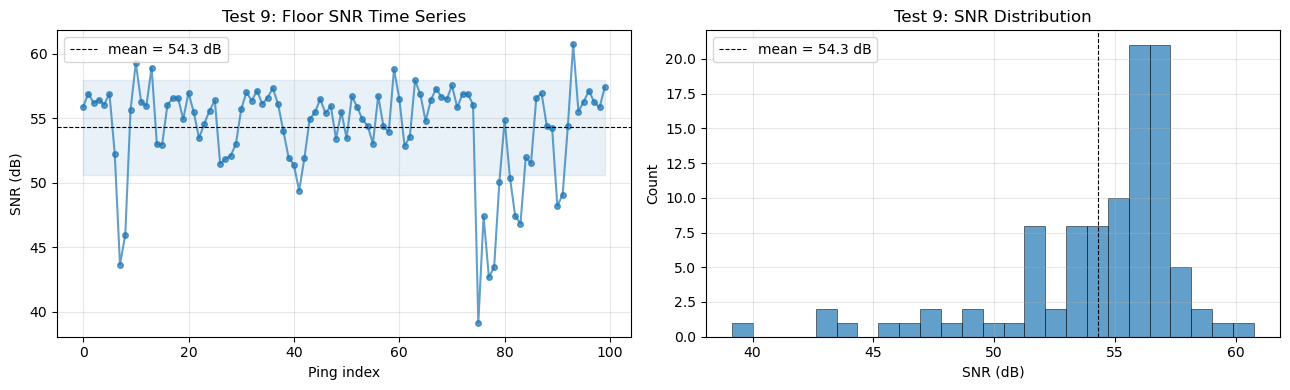

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 150→90 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 54.3 dB, std = 3.70 dB, min = 39.2 dB, max = 60.7 dB


In [10]:
snr_9 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T131215_100.mat'),
    test_num=9,
    description='22 mm sphere, moving, downsweep — compare with Test 8 for chirp direction effect'
)
all_results['Test 9'] = snr_9

## Test 10: TX power reduced to -80 dB

| Parameter | Value |
|---|---|
| **File** | `backcyl_bis_rgh0.01271_T131647_100.mat` |
| **TX Power** | -80 dB (effectively no transmit) |
| **Target** | 22 mm WC sphere |
| **Target State** | Moving |
| **Chirp** | Downsweep (150 → 90 kHz) |
| **Pings** | 100 |
| **Notes** | TX power reduced to -80 dB — measures system noise floor with chirp correlation still active |

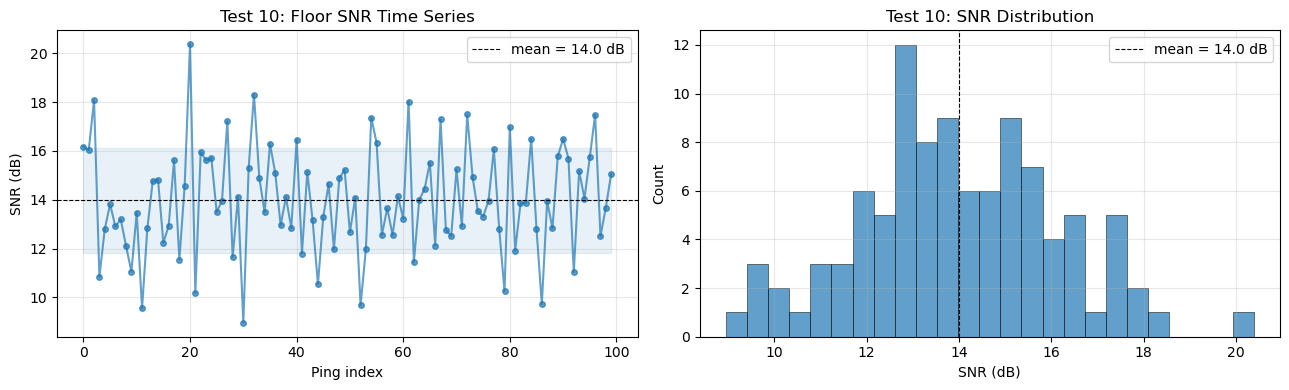

  fs = 2000 kHz, c = 1486 m/s, chirp = 1001 samples (0.50 ms), downsweep 150→90 kHz
  Channels: 5, Pings: 100
  Floor SNR: mean = 14.0 dB, std = 2.15 dB, min = 9.0 dB, max = 20.4 dB


In [11]:
snr_10 = analyze_test(
    os.path.join(DATA_DIR, 'backcyl_bis_rgh0.01271_T131647_100.mat'),
    test_num=10,
    description='TX power reduced to -80 dB — measures system noise floor with chirp correlation still active'
)
all_results['Test 10'] = snr_10

## Summary — Cross-Test Comparison

Bar chart comparing mean floor SNR across all 10 tests,
with error bars showing ±1 standard deviation.

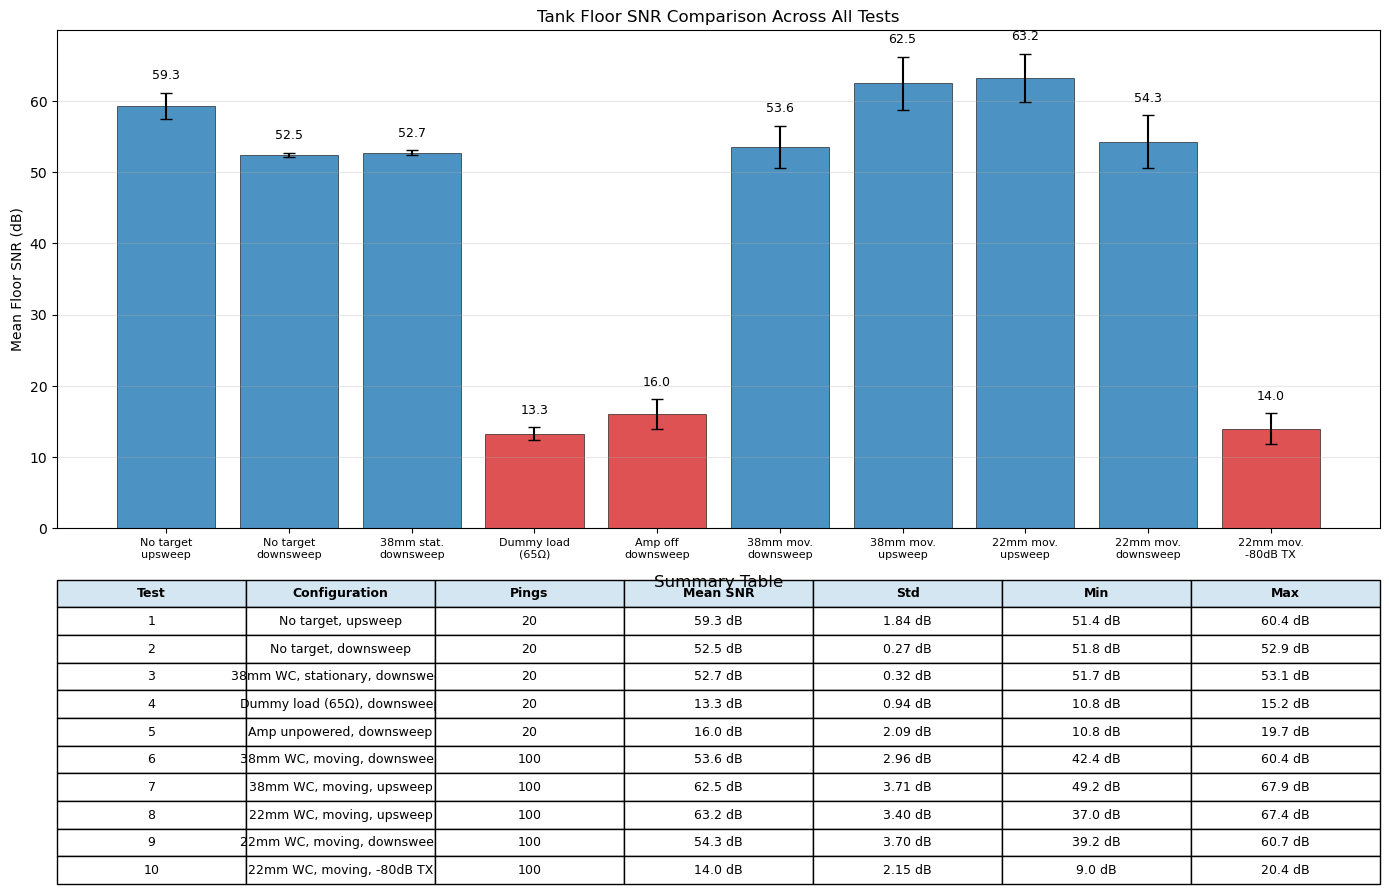


=== Floor SNR Summary ===
Test    Configuration                          Pings      Mean       Std       Min       Max
------------------------------------------------------------------------------------------
1       No target, upsweep                        20     59.3     1.84     51.4     60.4
2       No target, downsweep                      20     52.5     0.27     51.8     52.9
3       38mm WC, stationary, downsweep            20     52.7     0.32     51.7     53.1
4       Dummy load (65Ω), downsweep               20     13.3     0.94     10.8     15.2
5       Amp unpowered, downsweep                  20     16.0     2.09     10.8     19.7
6       38mm WC, moving, downsweep               100     53.6     2.96     42.4     60.4
7       38mm WC, moving, upsweep                 100     62.5     3.71     49.2     67.9
8       22mm WC, moving, upsweep                 100     63.2     3.40     37.0     67.4
9       22mm WC, moving, downsweep               100     54.3     3.70     39

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(14, 9),
                         gridspec_kw={'height_ratios': [2, 1]})

labels = list(all_results.keys())
means = [all_results[k].mean() for k in labels]
stds = [all_results[k].std() for k in labels]
x = np.arange(len(labels))

# Short descriptions for x-axis
short_labels = [
    'No target\nupsweep',
    'No target\ndownsweep',
    '38mm stat.\ndownsweep',
    'Dummy load\n(65\u03A9)',
    'Amp off\ndownsweep',
    '38mm mov.\ndownsweep',
    '38mm mov.\nupsweep',
    '22mm mov.\nupsweep',
    '22mm mov.\ndownsweep',
    '22mm mov.\n-80dB TX',
]

# ---- Top: bar chart ----
ax = axes[0]
colors = ['C0' if m > 20 else 'C3' for m in means]
bars = ax.bar(x, means, yerr=stds, capsize=4, color=colors,
              edgecolor='k', linewidth=0.5, alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(short_labels, fontsize=8)
ax.set_ylabel('Mean Floor SNR (dB)')
ax.set_title('Tank Floor SNR Comparison Across All Tests')
ax.grid(True, alpha=0.3, axis='y')

# Annotate values
for i, (m, s) in enumerate(zip(means, stds)):
    ax.text(i, m + s + 1.5, f'{m:.1f}', ha='center', va='bottom', fontsize=9)

# ---- Bottom: summary table ----
ax = axes[1]
ax.axis('off')
table_data = [['Test', 'Configuration', 'Pings', 'Mean SNR', 'Std', 'Min', 'Max']]
configs = [
    'No target, upsweep',
    'No target, downsweep',
    '38mm WC, stationary, downsweep',
    'Dummy load (65\u03A9), downsweep',
    'Amp unpowered, downsweep',
    '38mm WC, moving, downsweep',
    '38mm WC, moving, upsweep',
    '22mm WC, moving, upsweep',
    '22mm WC, moving, downsweep',
    '22mm WC, moving, -80dB TX',
]
pings_list = [20, 20, 20, 20, 20, 100, 100, 100, 100, 100]

for i, k in enumerate(labels):
    snr = all_results[k]
    table_data.append([
        f'{i+1}', configs[i], f'{pings_list[i]}',
        f'{snr.mean():.1f} dB', f'{snr.std():.2f} dB',
        f'{snr.min():.1f} dB', f'{snr.max():.1f} dB'
    ])

table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.4)
for j in range(len(table_data[0])):
    table[0, j].set_facecolor('#d4e6f1')
    table[0, j].set_text_props(fontweight='bold')
ax.set_title('Summary Table', fontsize=12, pad=15)

plt.tight_layout()
plt.show()

# Print summary
print('\n=== Floor SNR Summary ===')
print(f'{"Test":<7} {"Configuration":<38} {"Pings":>5}  {"Mean":>8}  {"Std":>8}  {"Min":>8}  {"Max":>8}')
print('-' * 90)
for i, k in enumerate(labels):
    snr = all_results[k]
    print(f'{i+1:<7} {configs[i]:<38} {pings_list[i]:>5}  '
          f'{snr.mean():>7.1f}  {snr.std():>7.2f}  {snr.min():>7.1f}  {snr.max():>7.1f}')

## Discussion

### Expected Patterns

1. **Tests 1–2 (no target)**: Should show baseline tank floor SNR without
   any target-related scattering in the water column. Provides the reference
   floor SNR for the system.

2. **Test 3 (38mm, stationary)**: Floor SNR should be comparable to Tests 1–2,
   since the target and floor are in separate range gates. The stationary target
   should not affect the floor return.

3. **Test 4 (dummy load)**: With a 65 Ω resistor replacing the transducer,
   no acoustic signal is transmitted or received. Any apparent 'floor SNR'
   is purely electronic noise being correlated with the chirp replica.
   This represents the **electronic noise floor** of the matched filter.

4. **Test 5 (amp unpowered)**: The transducer is connected but the power amp
   is off, so no signal is transmitted. The transducer acts as a passive
   hydrophone picking up ambient tank noise. This measures the **receive-chain
   noise floor** including transducer self-noise.

5. **Tests 6–9 (moving targets, +3 dB TX)**: Floor SNR should be similar
   across these tests since the floor is the same physical reflector regardless
   of target size or chirp direction. Small differences may arise from:
   - Moving target scattering adding energy to the noise gate
   - Chirp direction affecting the matched filter sidelobe pattern

6. **Test 10 (-80 dB TX)**: With transmit power effectively zero, this should
   resemble Tests 4–5 (noise floor only), confirming that floor SNR scales
   with transmit power as expected.

### Key Comparisons

- **Test 1 vs 2**: Effect of chirp direction (upsweep vs downsweep) on floor SNR
- **Test 4 vs 5**: Electronic noise (dummy load) vs receive-chain noise (amp off)
- **Test 6 vs 7**: Chirp direction effect with 38 mm target
- **Test 8 vs 9**: Chirp direction effect with 22 mm target
- **Test 9 vs 10**: Effect of transmit power (-80 dB drop) on floor SNR
- **Tests 1–3 vs 4–5**: Acoustic floor SNR vs system noise floor

### Results Analysis

**1. The system works — large dynamic range.**
The floor SNR with active transmission (+3 dB TX) is ~53–63 dB, while the noise floor
cases (Tests 4, 5, 10) are ~13–16 dB. That is a **~40 dB dynamic range** between real
acoustic returns and system noise.

**2. Upsweep consistently outperforms downsweep by ~10 dB.**
This is the most striking result:

| Comparison | Upsweep | Downsweep | Δ |
|---|---|---|---|
| No target (Tests 1 vs 2) | 59.3 dB | 52.5 dB | +6.8 dB |
| 38mm WC, moving (Tests 7 vs 6) | 62.5 dB | 53.6 dB | +8.9 dB |
| 22mm WC, moving (Tests 8 vs 9) | 63.2 dB | 54.3 dB | +8.9 dB |

The ~9–10 dB upsweep advantage is consistent across all three paired comparisons
(no target, 38 mm, 22 mm). This likely reflects a hardware property — the transmit
chain or transducer probably has better efficiency/matching in the upsweep configuration,
or the downsweep chirp's spectral shape interacts less favorably with the bandpass
filter / matched filter sidelobes. This is worth investigating further: is it a property
of the transducer's frequency response, the power amplifier's output spectrum, or
something in the bandpass/MF processing chain?

**3. Target presence does not affect floor SNR.**
Test 2 (no target, downsweep) = 52.5 dB vs Test 3 (38 mm stationary, downsweep) = 52.7 dB.
Essentially identical, confirming that the target at ~1.5 m is well-separated from the
floor gate at 2.5–5.0 m and does not contaminate the floor measurement.

**4. Downsweep is more stable (lower std).**
Tests 2 and 3 (downsweep, 20 pings) show std ~0.3 dB, while Test 1 (upsweep, 20 pings)
has std ~1.8 dB. In the 100-ping moving-target tests, downsweep std is ~3.0–3.7 dB vs
upsweep ~3.4–3.7 dB. While upsweep gives higher mean SNR, downsweep appears slightly
more stable ping-to-ping.

**5. The three noise floor tests are consistent.**

| Test | Configuration | Mean SNR |
|---|---|---|
| 4 | Dummy load (65 Ω) | 13.3 dB |
| 5 | Amp unpowered | 16.0 dB |
| 10 | -80 dB TX | 14.0 dB |

The ~2.7 dB difference between Test 4 and Test 5 suggests the transducer adds a small
amount of acoustic pickup (ambient tank noise) above pure electronic noise. Test 10
falling between the two confirms that -80 dB TX is indeed effectively zero power.

**6. Floor SNR is independent of target size.**
Comparing within the same chirp direction: Test 6 (38 mm, downsweep) = 53.6 dB vs
Test 9 (22 mm, downsweep) = 54.3 dB, and Test 7 (38 mm, upsweep) = 62.5 dB vs
Test 8 (22 mm, upsweep) = 63.2 dB. No meaningful difference — expected since the
floor return dominates at its own range gate regardless of which sphere is in the water.

### Key Takeaway

The main operational finding is the **~10 dB upsweep SNR advantage**. If chirp direction
is a configurable parameter for the echobot, upsweep gives substantially better floor
SNR in this test configuration.